# Predicting Tomorrow's Temperature in Tampa, Florida

Our objective is to predict tomorrow's temperature given x number of previous days temperatures. 

Our model, therefore, must accept x number of features -- each of which as the measures of temperatures, in sequence, over the past x days

To get our data, go to https://climatecenter.fsu.edu/climate-data-access-tools/downloadable-data and download weather data for the past 51 years. Select Tampa for the data set, and mean temperature as the value. Downlown this data (it will be in csv format) and store it in your working directory (the directory this notebook is in).


The following sequence of code will prepare our data for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

## Collect and prepare data for analysis

In [4]:
df = pd.read_csv('TampaTemp.csv',  parse_dates=True)

In [9]:
df.columns

Index(['COOPID', ' YEAR', ' MONTH', ' DAY', ' meanTemp'], dtype='object')

In [10]:
df = df[[' meanTemp']]  # watch the spaces in the column name 

In [5]:
df

,MEAN TEMP
0,70.0
1,71.5
2,72.0
3,71.5
4,73.5
...,...
18654,54.0
18655,61.5
18656,68.0
18657,71.0


In [12]:
df[' meanTemp'].isna().sum()

0

In [13]:
row_count = df.shape[0] # store the number of obersvations (daily temperature readings)
row_count

18661

In [14]:
temps = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of temperatures
temps.shape

(18661, 1)

In [15]:
sequence_length = 60  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [16]:
temps = temps[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
temps.shape

(18660, 1)

In [17]:
temps = temps.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
temps

array([[ 51.5,  64. ,  74. , ...,  75. , -99.9,  75. ],
       [ 74. ,  66.5,  50.5, ...,  80. ,  80. ,  80.5],
       [ 78.5,  72. ,  71.5, ...,  80.5,  82.5,  81.5],
       ...,
       [ 81.5,  82. ,  85.5, ...,  79.5,  82. ,  84.5],
       [ 83. ,  83.5,  84.5, ...,  70. ,  66.5,  74.5],
       [ 76.5,  74. ,  65. , ...,  74. ,  76. ,  74.5]])

In [12]:
# we can now see that our days have been organized into rows of sequence length. 

In [19]:
# create our X and y. 
# X will be the 59 days prior...
X = temps[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = temps[:, -1] # all rows, only the last column

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(217, 59, 1)
(94, 59, 1)


In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [23]:
# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
7/7 [==============================] - 4s 118ms/step - loss: 5211.1338 - root_mean_squared_error: 72.1882 - val_loss: 5136.8047 - val_root_mean_squared_error: 71.6715
Epoch 2/600
7/7 [==============================] - 0s 27ms/step - loss: 5106.5928 - root_mean_squared_error: 71.4604 - val_loss: 5036.9937 - val_root_mean_squared_error: 70.9718
Epoch 3/600
7/7 [==============================] - 0s 27ms/step - loss: 4996.1992 - root_mean_squared_error: 70.6838 - val_loss: 4918.2173 - val_root_mean_squared_error: 70.1300
Epoch 4/600
7/7 [==============================] - 0s 27ms/step - loss: 4892.2109 - root_mean_squared_error: 69.9443 - val_loss: 4841.7192 - val_root_mean_squared_error: 69.5825
Epoch 5/600
7/7 [==============================] - 0s 25ms/step - loss: 4808.7065 - root_mean_squared_error: 69.3448 - val_loss: 4735.6782 - val_root_mean_squared_error: 68.8163
Epoch 6/600
7/7 [==============================] - 0s 31ms/step - loss: 4699.6353 - root_mean_squared_error: 

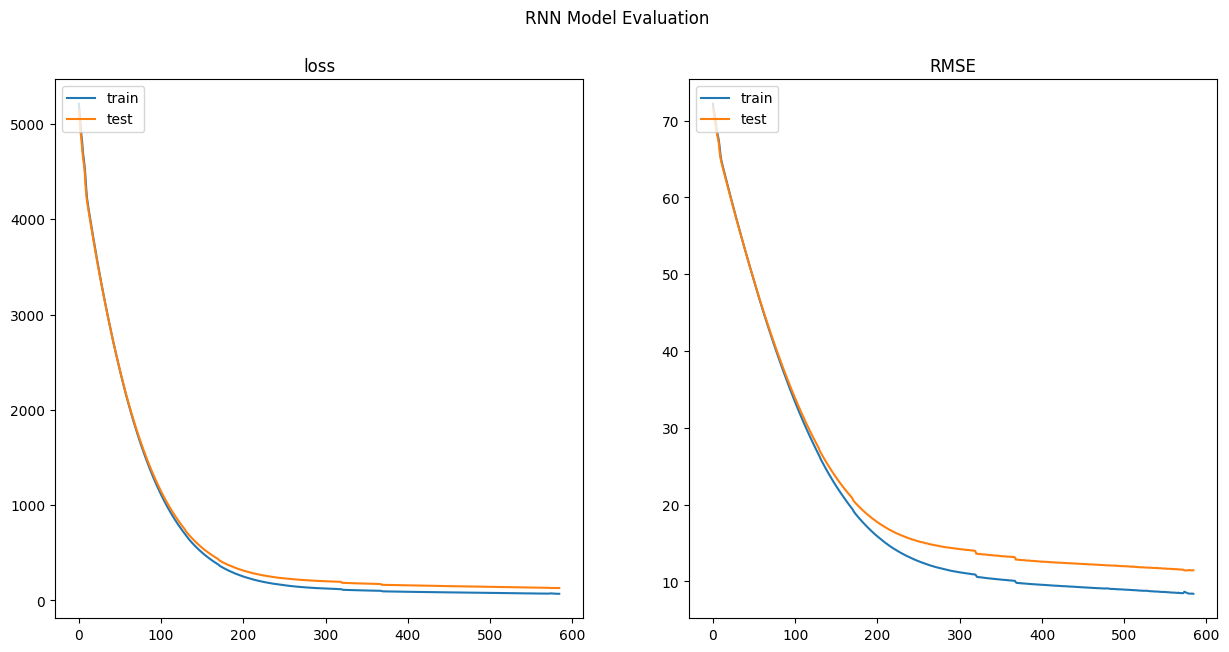

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [26]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

mean_squared_error(y_test, y_pred)**0.5


3/3 [==============================] - 0s 8ms/step


11.447271506894447

Now, let's say our past 59 days of temperatures were as follow....

In [27]:
prior_days = np.array(
    [
        77,75,79,85,78,75,81,83,87,80, 
        76,72,81,82,79,78,82,80,81,81, 
        74,76,82,83,75,77,83,81,83,80, 
        79,77,78,84,76,76,82,83,85,83, 
        76,74,79,85,77,72,83,82,83,84, 
        78,77,80,81,78,74,81,84,87, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 59, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

In [28]:
model.predict(prior_days) # note the structure of the prediction

1/1 [==============================] - 0s 312ms/step


array([[81.605415]], dtype=float32)

In [29]:
tomorrows_temp = model.predict(prior_days)[0][0] # we see the predicted temp is embedded inside two dimensions

1/1 [==============================] - 0s 39ms/step


In [24]:
print(f"Tomorrow's predicted temperature is {tomorrows_temp:.2f} degrees Fahrenheit.")

Tomorrow's predicted temperature is 82.40 degrees Fahrenheit.
